### Aqueous Organic Estimator

Authors: Grayson Boyer, Jordyn Robare

A notebook for estimating the thermodynamic properties and HKF parameters of aqueous organic molecules using second order group additivity methods.

Date modified: 7/13/2020

### notes for Jordyn 7/13/2020:

Ensure the sigfig package is installed:

```conda activate my-rdkit-env``` and then ```pip install sigfig```

In [1]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
import math
import sigfig
import pubchempy as pcp
import os
import thermo
from chemparse import parse_formula

# for benson group additivity
from pgradd.GroupAdd.Library import GroupLibrary
import pgradd.ThermoChem

In [2]:
# load functions

def match_group(name, pattern):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    mol = Chem.MolFromSmiles(this_smile)
    functional_group = Chem.MolFromSmarts(pattern)
    matches = mol.GetSubstructMatches(functional_group)
    return len(matches)

def match_groups(name, patterns, draw=False):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    mol = Chem.MolFromSmiles(this_smile) #convert smiles from internet to usable form for rdkit
    pattern_matches = [len(mol.GetSubstructMatches(Chem.MolFromSmarts(pattern))) for pattern in patterns] #!!!
    # figure out how higher order groups were estimated and see if we can convert to
    # 2nd order groups - see if that makes any sense
    
    match_dict = dict(zip(patterns, pattern_matches))
    
    ### check that total formula of groups matches that of the molecule
    
    # create a dictionary of element matches
    total_formula_dict = {}
    for match in match_dict.keys():
        this_match = parse_formula(pattern_dict[match])
        for element in this_match.keys():
            this_match[element] *= match_dict[match]
            if element in total_formula_dict:
                total_formula_dict[element] += this_match[element]
            else:
                total_formula_dict[str(element)] = 0
                total_formula_dict[element] += this_match[element]
    
    # remove keys of elements with a value of 0 (e.g. "H":0.0)
    for key in list(total_formula_dict.keys()):
        if total_formula_dict[key] == 0.0:
            total_formula_dict.pop(key, None)
    
    # retrieve individual charges that contribute to net charge
    atomic_info = this_compound[0].record["atoms"]
    chargedict = {}
    if "charge" in atomic_info.keys():
        all_charges = [chargedict.get("value", 0) for chargedict in atomic_info["charge"]]
        pos_charge = sum([charge for charge in all_charges if charge > 0])
        neg_charge = abs(sum([charge for charge in all_charges if charge < 0]))
        if pos_charge > 0:
            chargedict['+']=float(pos_charge)
        if neg_charge > 0:
            chargedict['-']=float(neg_charge)
    else:
        chargedict = {}

    # perform the comparison
    test_dict = parse_formula(this_compound[0].molecular_formula)
    test_dict.update(chargedict)
    if total_formula_dict != test_dict:
        print("Warning! The formula of", name, "does not equal the the elemental composition of the matched groups! This could be because the structure of", name, "is missing representative groups.")
        print("Formula of", name +":")
        pcp_dict = parse_formula(this_compound[0].molecular_formula)
        pcp_dict.update(chargedict)
        print(pcp_dict)
        print("Total formula of group matches:")
        print(total_formula_dict)
    
    ### create a png and svg of the molecule
    if draw:
        molSize=(450,150)
        mc = Chem.Mol(mol.ToBinary())
        if not mc.GetNumConformers():
            #Compute 2D coordinates
            rdDepictor.Compute2DCoords(mc)
        # init the drawer with the size
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
        #draw the molcule
        drawer.DrawMolecule(mc)
        drawer.FinishDrawing()
        # get the SVG string
        svg = drawer.GetDrawingText()
        # fix the svg string and display it
    #     display(SVG(svg.replace('svg:','')))
        os.makedirs("mol_svg",exist_ok=True)
        os.makedirs("mol_png",exist_ok=True)
        #Draw.MolToFile( mol, "mol_svg/"+name+".svg" )
        Draw.MolToFile( mol, "mol_png/"+name+".png" )
    return match_dict


def print_group_matches(name, patterns): #unused function
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    mol = Chem.MolFromSmiles(this_smile)
    for pattern in patterns:
        functional_group = Chem.MolFromSmarts(pattern)
        matches = mol.GetSubstructMatches(functional_group)
        if(len(matches) != 0):
            print(len(matches), pattern)

def display_molecule(name, save=False):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    mol = Chem.MolFromSmiles(this_smile)
    molSize=(450,150)
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        #Compute 2D coordinates
        rdDepictor.Compute2DCoords(mc)
    # init the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    #draw the molcule
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    # get the SVG string
    svg = drawer.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))
    if save:
        os.makedirs("mol_svg",exist_ok=True)
        os.makedirs("mol_png",exist_ok=True)
        #Draw.MolToFile( mol, "mol_svg/"+name+".svg" )
        Draw.MolToFile( mol, "mol_png/"+name+".png" )

def get_smarts(name):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    return Chem.MolToSmarts(Chem.MolFromSmiles(this_smile))

def get_smiles(name):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    return Chem.MolFromSmiles(this_smile)

In [3]:


def BensonG(name, print_groups=False):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    lib = GroupLibrary.Load('BensonGA')
    descriptors = lib.GetDescriptors(this_smile)
    if print_groups:
        print(descriptors)
    thermochem = lib.Estimate(descriptors,'thermochem')
    return thermochem.get_G(298.15, units="kJ/mol")

def BensonHS(name, print_groups=False):
    this_compound = pcp.get_compounds(name, "name")
    this_smile = this_compound[0].canonical_smiles
    lib = GroupLibrary.Load('BensonGA')
    descriptors = lib.GetDescriptors(this_smile)
    if print_groups:
        print(descriptors)
    thermochem = lib.Estimate(descriptors,'thermochem')
    return thermochem.get_H(298.15, units="kJ/mol"), thermochem.get_S(298.15, units="J/mol/K")

H, S = BensonHS("hexane")
print("Calculated from H and S:", H - 298.15*(S - 949.2)/1000)
print("Calculated from get_G:", BensonG("hexane"))

Calculated from H and S: -7.7324494251975295
Calculated from get_G: -290.7364294251975


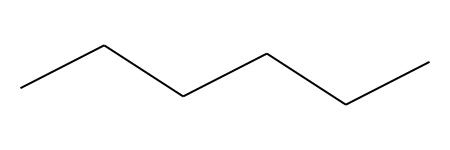

Ideal Gas Gf = -0.36 kJ/mol


In [4]:
#check if thermo package calls on more complex databases than the original

# molecule = "2-methoxypropane" #secondary ether
#molecule = "2-methylhexanenitrile" #secondary ester
molecule = "hexane" #secondary ester

mol = get_smiles(molecule)
display_molecule(molecule)
J = thermo.Joback(mol) 
mol_Gf = J.estimate()['Gf']/1000 # ideal gas Joback estimation of the Gibbs free energy of formation
print("Ideal Gas Gf =", round(mol_Gf, 2), "kJ/mol")

In [5]:
pattern_dict = {
    
    #corrections suggested in literature
    "[O](-C[CH3])-C[CH2]": "", #verified with 1-ethoxybutane, correction for ethoxyalkanes
    "O-[CH2]-[CH2]-O": "", #verified with 1,2-diethoxyethane, correction for di- and polyethers     
    "[CH2](-[CH2]-C#N)-C#N": "", #verified for butanedinitrile, for correction
    "[CH2](-[CH2]-[CH2]-C#N)-C#N": "", #verified for pentanedinitrile, for correction    
  
    #our corrections based on higher order group contributions in papers
    "N#C-[CH](-C)-C": "", #verified for 2-methylhexanenitrile, use for correction
    "N#C-[CH2]-C": "", #verified for hexanenitrile, use for correction
    "C-[CH2]-C=O": "", #verified with octanoic acid, use for correction
    "C-[CH](-C)-C=O": "", #2-methyloctanoic acid, use for correction
    "C-[C](-C)(-C)-C=O": "", #2,2-dimethyloctanoic acid, use for correction
    "C-[C](=O)-O-C": "", #ethyl propanoate, provisional ester group, correction on top of other groups: [O]=C, C-[O]-C
    "[CH](=O)-OC": "", #isopropyl formate, provisional methanoate group, correction on top of other groups: [O]=C, C-[O]-C
    "O=C-O-[CX4H1](-C)-C":"", #secondary ester, isopropyl ethanoate, correction on top of secondary ether
    "C-O-[CX4H0](-C)(-C)-C":"", #tertiary ester, tert-butyl ethanoate, correction on top of tertiary ether
    
    #can't match ethyne, ethylene oxide,   
    
    #imines
    "C-[C](-C)=N": "C", #verified with hexafluoroacetone imine TypeError: unsupported operand type(s) for +=: 'float' and 'str'
    "C=[NH]" : "NH", #verified with hexafluoroacetone imine
    
   #alkenes
    "C=[CX2H0]=C": "C", #verified with propadiene
    "C=[CX3H2]": "CH2", #verified with propadiene ERROR
    "C=[CX3H1]-C": "CH", #verified with propene
    "C=[CX3H0](-C)-C": "C", #verified with methyl cyanoacrylate ERROR
    
    #alkynes
    "C#[CX2H1]": "CH", #verified with propyne ERROR
    "C-[CX2H0]#C": "C", #verified with 2-butyne ERROR
    
    #tropylium
    "c[cX3H1+]c": "CH+", #verified with tropylium
    
    #pyrrole
    "n[cX3H1]c": "CH", #verified with pyrrole ERROR
    "c[nX3H1]c": "NH", #verified with pyrrole ERROR
    
    #cyano/nitrile groups
    "C#[NX1H0]": "N", #verified with cyanobenzene ERROR
    "C-[CX2H0]#N": "C", #2-methylhexanenitrile
    
    #carbon monoxide
    "O#[CX1H0-]": "C-", #verified with carbon monoxide
    "C#[OX1H0+]": "O+", #verified with carbon monoxide
   
    #nitro groups
    "N-[O-]": "O-", #verified with nitrobenzene ERROR
    "N=[O]": "O",  #verified with nitrobenzene ERROR
    
    #halogens
    "C-[Br]": "Br", #verified with 2-bromobutanamide ERROR
    "C-[CX4H2]-Br": "CH2", #verified with 2-bromoethanamide
    "C-[CX4H1](-C)-Br": "CH", #verified with 2-bromobutanamide
    "C-[C](-C)(-C)-Br": "C",
    "C-[C](-Br)(-Br)-Br": "C", #verified with hexabromoacetone
    "C-[C](-Br)=O": "C", #verified with acetyl bromide
    
    "C-[Cl]": "Cl", 
    "C-[CX4H2]-Cl": "CH2", 
    "C-[CX4H1](-C)-Cl": "CH",
    "C-[C](-C)(-C)-Cl": "C",
    "C-[C](-Cl)(-Cl)-Cl": "C", 
    "C-[C](-Cl)=O": "C",

    "C-[F]": "F", 
    "C-[CX4H2]-F": "CH2", 
    "C-[CX4H1](-C)-F": "CH",
    "C-[C](-C)(-C)-F": "C",
    "C-[C](-F)(-F)-F": "C",
    "C-[C](-F)=O": "C",

    "C-[I]": "I", 
    "C-[CX4H2]-I": "CH2", 
    "C-[CX4H1](-C)-I": "CH",
    "C-[C](-C)(-C)-I": "C",
    "C-[C](-I)(-I)-I": "C", 
    "C-[C](-I)=O": "C",
    
    # aliphatic carbon
    "C-[CX4H3]":"CH3", #verified for hexane
    "C-[CX4H2]-C":"CH2", #verified for hexane
    "C-[CX4H1](-C)-C":"CH", #verified for 2-methylpropane
    "C-[CX4H0](-C)(-C)-C":"C1", #verified for 2,2-dimethylpropane
    
    # primary, secondary, tertiary alcohols, ethers, and esters
    "O-[CX4H3]":"CH3", #verified for methoxyethane
    "O-[CX4H2]-C":"CH2", #verified for methoxyethane
    "C-[CX4H1](-C)[OH]":"CH", #isopropanol, secondary alcohol
    "C-[CX4H0](-C)(-C)[OH]":"C", #1,1-dimethylethanol, tertiary alcohol
    "C-[CX4H1](-O-C)-C":"CH", #verified for 2-methoxypropane, secondary ether
    "C-O-[CX4H0](-C)(-C)-C":"C", #verified for 2-methoxy-2-methylpropane, tertiary ether
    "C-[OX2H]":"OH", #verified for methanol
    "C-[O-]": "O-", #verified with formate
    "C-[OX2]-C": "O", #verified for methoxyethane
    "O-[CH2]-O": "CH2",
    "O-[CH](-C)-O": "CH",
    
    #primary amines
    "C-[CX4H2]-N": "CH2", #verified with ethanolamine ERROR
    "C-[NX3H2]": "NH2", #verified with ethanolamine, will not longer match with dimethylammonium
    "C-[NH3+]": "NH3+", #verified with ethylammonium
    
    #things connected to nitrogens
    "N-[CX4H3]": "CH3", #verified with dimethylamine ERROR
    "N-[CX4H1](-C)-C": "CH1", #verified with 1-methylethylamine ERROR
    "N-[CX4H0](-C)(-C)-C": "C", #verified with 1,1-dimethylethylamine ERROR
    
    #secondary amines
    "C-[NX3]-C": "NH1", #verified with dimethyLamine ERROR
    "C-[NH2+]-C": "NH2+", #verified with dimethylammonium ERROR
    
    #tertiary amines
    "C-[NX3](-C)-C": "N", #verified for trimethylamine ERROR
    "C-[NH1+](-C)-C": "NH+", #verified for trimethylammonium
    
    #quaternary amines
    "C-[N+](-C)(-C)-C": "N+", #verified for tetramethylammonium
   
    #thiols
    "C-[SX2H1]": "SH", #verified with methanethiol ERROR
    "C-[S-]": "S-", #verified with methanethiolate
    "C-[SX2]-C": "S",
    "S-[CH3]": "CH3", #verified with methanethiol
    "S-[CH2]-C": "CH2", 
    "S-[CH](-C)-C": "CH", #verified with 3-pentanethiol ERROR
    "S-[C](-C)(-C)-C": "C", 
    "S-[c](c)c": "C", #verified with thiophenol ERROR
    "c-[SH]": "SH", #verified with thiophenol 
    "c-[S-]": "S-", 
    "c[s]c": "S", #verified with thiophene ERROR
    "s[c]c": "C", #verified with thiophene
    "c-[S]-S": "S", #verified with diphenyl disulfide ERROR
    "S-[c](c)c": "C", #verified with diphenyl disulfide
    "S-[S]-C": "S", 
    "S-[S]-S": "S",
    
    #carbonyls
    "C=[O]": "O", #verified with formaldehyde
    "O=[CX3H2]": "CH2", #verified with formaldehyde
    "O=[CX3H1]-O": "CH", #verified with formic acid - group can't be separated Plyasunov et al., 2004a
    "O=[CX3](-O)-O": "C", #verified with carbonic acid
    "O=[CX3](-C)-O": "C", #verified with acetic acid- group can't be separated Plyasunov et al., 2004a
    "O=[CX3](-O)-c": "C", #verified with benzoic acid
    "O=[CX3H1]-N": "CH", #verified with methanamide ERROR 
    "O=[CX3](-C)-N": "C", #verified with ethanamide ERROR
    "O=[CX3](-c)-N": "C", #verified with benzamide ERROR
    "O=[CX3H1]-c": "CH", #verified with benzaldehyde
    "C-[C](-C)=O": "C", #verified with hexabromoacetone
    
    #sulfur carbonyls
    "C=[S]": "S", #verified with thiobenzophenone #ERROR
    "S=[CX3H2]": "CH2", #verified with thioformaldehyde
    "S=[CX3H1]-O": "CH", #verified with
    "S=[CX3](-O)-O": "C", #verified with
    "S=[CX3](-C)-O": "C", #verified with
    "S=[CX3](-O)-c": "C", #verified with
    "S=[CX3H1]-N": "CH", #verified with 
    "S=[CX3](-C)-N": "C", #verified with
    "S=[CX3](-c)-N": "C", #verified with
    "S=[CX3H1]-c": "CH", #verified with 
    "C-[C](-C)=S": "C", #verified with 
    
     #aromatic
    "c[cX3H+0]c": "CH", #verified with benzene, 
    "c[cX3H0](c)c": "C", #verified with napthalene
    "c-[CX4H2]-c": "CH2", #verified with fluorene
    
    #aromatic branching
    "c-[CX2H0]#N": "C", ##verified with cyanobenzene ERROR
    "c-[NX3H0+](=O)-O": "N+", #verified with nitrobenzene ERROR
    "c-[NX3H2]": "NH2", #verified with aniline ERROR
    "c[cX3](-N)c": "C", #verified with methylbenzene
    "c-[CX4H3]": "CH3", #verified with methylbenzene
    "c[cX3](-C)c": "C", #verified with methylbenzene
    "c-[CX4H2]-C": "CH2", #verified with ethylbenzene
    "c-[CX4H1](-C)-C": "CH", #verified with isopropylbenzene
    "c-[CX4H0](-C)(-C)-C": "C", #verified with tert-butylbenzene
    "c-[CX3H0](=O)-c": "C", #verified with benzophenone
    "c-[CX3H0](=S)-c": "C", #verified with sulfobenzophenone
    
    #aromatic nitrogen
    #esters
}

In [6]:
# test group matching and error messages
try:
    test_result = match_groups(molecule, pattern_dict.keys(), draw=False)
except:
    print("test failed... maybe the molecule name is spelled incorrectly?")

test_result

{'[O](-C[CH3])-C[CH2]': 0,
 'O-[CH2]-[CH2]-O': 0,
 '[CH2](-[CH2]-C#N)-C#N': 0,
 '[CH2](-[CH2]-[CH2]-C#N)-C#N': 0,
 'N#C-[CH](-C)-C': 0,
 'N#C-[CH2]-C': 0,
 'C-[CH2]-C=O': 0,
 'C-[CH](-C)-C=O': 0,
 'C-[C](-C)(-C)-C=O': 0,
 'C-[C](=O)-O-C': 0,
 '[CH](=O)-OC': 0,
 'O=C-O-[CX4H1](-C)-C': 0,
 'C-O-[CX4H0](-C)(-C)-C': 0,
 'C-[C](-C)=N': 0,
 'C=[NH]': 0,
 'C=[CX2H0]=C': 0,
 'C=[CX3H2]': 0,
 'C=[CX3H1]-C': 0,
 'C=[CX3H0](-C)-C': 0,
 'C#[CX2H1]': 0,
 'C-[CX2H0]#C': 0,
 'c[cX3H1+]c': 0,
 'n[cX3H1]c': 0,
 'c[nX3H1]c': 0,
 'C#[NX1H0]': 0,
 'C-[CX2H0]#N': 0,
 'O#[CX1H0-]': 0,
 'C#[OX1H0+]': 0,
 'N-[O-]': 0,
 'N=[O]': 0,
 'C-[Br]': 0,
 'C-[CX4H2]-Br': 0,
 'C-[CX4H1](-C)-Br': 0,
 'C-[C](-C)(-C)-Br': 0,
 'C-[C](-Br)(-Br)-Br': 0,
 'C-[C](-Br)=O': 0,
 'C-[Cl]': 0,
 'C-[CX4H2]-Cl': 0,
 'C-[CX4H1](-C)-Cl': 0,
 'C-[C](-C)(-C)-Cl': 0,
 'C-[C](-Cl)(-Cl)-Cl': 0,
 'C-[C](-Cl)=O': 0,
 'C-[F]': 0,
 'C-[CX4H2]-F': 0,
 'C-[CX4H1](-C)-F': 0,
 'C-[C](-C)(-C)-F': 0,
 'C-[C](-F)(-F)-F': 0,
 'C-[C](-F)=O': 0,
 'C-[I]':

In [7]:
# load alcohol test csv
df_inp = pd.read_csv("alcohol_test_mini.csv")
df_inp.head()

,compound,formula,DhyG,DhyH,DhyCp,V
0,methanol,CH4O,-13.21,-45.13,114.0,38.15
1,ethanol,C2H6O,-13.00,-52.59,199.0,55.10
2,1-propanol,C3H8O,-12.38,-57.65,268.0,70.70
3,2-propanol,C3H8O,-11.93,-58.50,272.0,71.80
4,1-butanol,C4H10O,-11.88,-61.72,335.0,86.60


In [8]:
# get list of molecules to look up
molecules = df_inp["compound"]
molecules.head()

0      methanol
1       ethanol
2    1-propanol
3    2-propanol
4     1-butanol
Name: compound, dtype: object

In [9]:
# create a df of names and groups
df = pd.DataFrame()
vetted_mol = []
for molecule in molecules:
    try:
        df = df.append(match_groups(molecule, pattern_dict.keys(), draw=True), ignore_index=True)
        vetted_mol.append(molecule) #matches online
    except:
        pass
df.index = vetted_mol

In [10]:
df.head()

,C#[CX2H1],C#[NX1H0],C#[OX1H0+],C-O-[CX4H0](-C)(-C)-C,C-[Br],C-[CH2]-C=O,C-[CH](-C)-C=O,C-[CX2H0]#C,C-[CX2H0]#N,C-[CX4H0](-C)(-C)-C,...,c-[S]-S,c[cX3H+0]c,c[cX3H0](c)c,c[cX3H1+]c,c[cX3](-C)c,c[cX3](-N)c,c[nX3H1]c,c[s]c,n[cX3H1]c,s[c]c
methanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ethanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-propanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-propanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-butanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
props = df_inp[[colname for colname in df_inp.columns.values if colname not in ["compound"]]]
prop_names = df_inp.columns.values[df_inp.columns.values != 'compound']
props.index = molecules
props.head()

,formula,DhyG,DhyH,DhyCp,V
compound,,,,,
methanol,CH4O,-13.21,-45.13,114.0,38.15
ethanol,C2H6O,-13.00,-52.59,199.0,55.10
1-propanol,C3H8O,-12.38,-57.65,268.0,70.70
2-propanol,C3H8O,-11.93,-58.50,272.0,71.80
1-butanol,C4H10O,-11.88,-61.72,335.0,86.60


In [12]:
df_c = pd.concat([props, df], axis=1, sort=False)
df_c.to_csv("organic_second_order_alc_test.csv", index_label="compound")
df_c.head()

,formula,DhyG,DhyH,DhyCp,V,C#[CX2H1],C#[NX1H0],C#[OX1H0+],C-O-[CX4H0](-C)(-C)-C,C-[Br],...,c-[S]-S,c[cX3H+0]c,c[cX3H0](c)c,c[cX3H1+]c,c[cX3](-C)c,c[cX3](-N)c,c[nX3H1]c,c[s]c,n[cX3H1]c,s[c]c
compound,,,,,,,,,,,,,,,,,,,,,
methanol,CH4O,-13.21,-45.13,114.0,38.15,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ethanol,C2H6O,-13.00,-52.59,199.0,55.10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-propanol,C3H8O,-12.38,-57.65,268.0,70.70,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-propanol,C3H8O,-11.93,-58.50,272.0,71.80,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-butanol,C4H10O,-11.88,-61.72,335.0,86.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# remove columns with no matches
df_c = df_c.loc[:, (df_c.sum(axis=0) != 0)]
df_c.head()

,formula,DhyG,DhyH,DhyCp,V,C-[CX4H0](-C)(-C)-C,C-[CX4H0](-C)(-C)[OH],C-[CX4H1](-C)-C,C-[CX4H1](-C)[OH],C-[CX4H2]-C,C-[CX4H3],C-[OX2H],O-[CX4H2]-C,O-[CX4H3]
compound,,,,,,,,,,,,,,
methanol,CH4O,-13.21,-45.13,114.0,38.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
ethanol,C2H6O,-13.00,-52.59,199.0,55.10,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1-propanol,C3H8O,-12.38,-57.65,268.0,70.70,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2-propanol,C3H8O,-11.93,-58.50,272.0,71.80,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
1-butanol,C4H10O,-11.88,-61.72,335.0,86.60,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0


In [14]:
# load compiled 2nd order group contribution (gc) data
df_gc = pd.read_csv("group_contribution_data.csv", dtype=str)
df_gc.head()

,group,Gh,Gh_err,Gh_n,Hh,Hh_err,Hh_n,Cph,Cph_err,Cp_count,V,V_err,V_count,refs,smarts,elem,published_notes,personal_notes
0,Yo,7.95,NaN,NaN,-2.29,NaN,NaN,0,NaN,NaN,1.12,NaN,NaN,Plyasunov et al. 2004a,Yo,NaN,NaN,material point
1,C-(C)(H)3,3.72,0.07,136,-8.19,0.18,99,132,4,38,25.56,0.64,52,Plyasunov et al. 2004a,C-[CX4H3],CH3,NaN,NaN
2,C-(C)(H)2,0.68,0.03,96,-3.52,0.09,63,62,2,20,15.61,0.11,29,Plyasunov et al. 2004a,C-[CX4H2]-C,CH2,NaN,typo in table
3,C-(C)(H),-1.93,0.16,32,2.34,0.54,22,-17,10,2,5.96,0.8,8,Plyasunov et al. 2004a,C-[CX4H1](-C)-C,CH,NaN,typo in table
4,C-(C)4,-4.6,0.32,7,10.87,1,4,-97,12,2,-4.08,1.41,2,Plyasunov et al. 2004a,C-[CX4H0](-C)(-C)-C,C,NaN,NaN


In [15]:
# set index to smarts code
df_gc = df_gc.set_index("smarts")
df_gc.head()

,group,Gh,Gh_err,Gh_n,Hh,Hh_err,Hh_n,Cph,Cph_err,Cp_count,V,V_err,V_count,refs,elem,published_notes,personal_notes
smarts,,,,,,,,,,,,,,,,,
Yo,Yo,7.95,NaN,NaN,-2.29,NaN,NaN,0,NaN,NaN,1.12,NaN,NaN,Plyasunov et al. 2004a,NaN,NaN,material point
C-[CX4H3],C-(C)(H)3,3.72,0.07,136,-8.19,0.18,99,132,4,38,25.56,0.64,52,Plyasunov et al. 2004a,CH3,NaN,NaN
C-[CX4H2]-C,C-(C)(H)2,0.68,0.03,96,-3.52,0.09,63,62,2,20,15.61,0.11,29,Plyasunov et al. 2004a,CH2,NaN,typo in table
C-[CX4H1](-C)-C,C-(C)(H),-1.93,0.16,32,2.34,0.54,22,-17,10,2,5.96,0.8,8,Plyasunov et al. 2004a,CH,NaN,typo in table
C-[CX4H0](-C)(-C)-C,C-(C)4,-4.6,0.32,7,10.87,1,4,-97,12,2,-4.08,1.41,2,Plyasunov et al. 2004a,C,NaN,NaN


In [16]:
# get a list of relevent groups
groups = [group for group in df_c.columns if group not in ["formula","DhyG","DhyH","DhyCp","V"]]
groups

['C-[CX4H0](-C)(-C)-C',
 'C-[CX4H0](-C)(-C)[OH]',
 'C-[CX4H1](-C)-C',
 'C-[CX4H1](-C)[OH]',
 'C-[CX4H2]-C',
 'C-[CX4H3]',
 'C-[OX2H]',
 'O-[CX4H2]-C',
 'O-[CX4H3]']

In [17]:
def findHKF(Gh=float('NaN'), Vh=float('NaN'), Cp=float('NaN'),
            Gf=float('NaN'), Hf=float('NaN'), Saq=float('NaN'),
            charge=float('NaN'), J_to_cal=True):

    # define eta (angstroms*cal/mol)
    eta = (1.66027*10**5)

    # define YBorn (1/K)
    YBorn = -5.81*10**-5

    # define QBorn (1/bar)
    QBorn = 5.90*10**-7

    # define XBorn (1/K^2)
    XBorn = -3.09*10**-7

    # define abs_protonBorn (cal/mol), mentioned in text after Eq 47 in Shock and Helgeson 1988
    abs_protonBorn = (0.5387 * 10**5)


    if not pd.isnull(Gh) and charge == 0:

        # find omega*10^-5 (j/mol) if neutral and Gh available
        HKFomega = 2.61+(324.1/(Gh-90.6)) # Eq 8 in Plyasunov and Shock 2001

    elif charge == 0:

        # find omega*10^-5 (j/mol) if neutral and Gh unavailable
        HKFomega = (10^-5)*((-1514.4*(Saq/4.184)) + (0.34*10**5))*4.184 # Eq 61 in Shock and Helgeson 1990 for NONVOLATILE neutral organic species

    elif charge != 0:

        # define alphaZ (described in text after Eq 59 in Shock and Helgeson 1990)
        if (abs(charge) == 1):
            alphaZ = 72
        elif (abs(charge) == 2):
            alphaZ = 141
        elif (abs(charge) == 3):
            alphaZ = 211
        elif (abs(charge) == 4):
            alphaZ = 286
        else:
            alphaZ = float('NaN')

        # define BZ
        BZ = ((-alphaZ*eta)/(YBorn*eta - 100)) - charge*abs_protonBorn # Eq 55 in Shock and Helgeson 1990

        # find ion omega*10^-5, (J/mol) if charged
        HKFomega = (10^-5)*(-1514.4*(Saq/4.184) + BZ)*4.184 # Eq 58 in Shock and Helgeson 1990

        ### METHOD FOR INORGANIC AQUEOUS ELECTROLYTES USING SHOCK AND HELGESON 1988:

            # find rej (angstroms), ions only
            #rej <- ((charge^2)*(eta*YBorn-100))/((Saq/4.184)-71.5*abs(charge)) # Eqs 46+56+57 in Shock and Helgeson 1988

            # find ion absolute omega*10^-5, (cal/mol)
            #HKFomega_abs_ion <- (eta*(charge^2))/rej # Eq 45 in Shock and Helgeson 1988

            # find ion omega*10^-5, (J/mol)
            #HKFomega2 <- (10^-5)*(HKFomega_abs_ion-(charge*abs_protonBorn))*4.184 # Eq 47 in Shock and Helgeson 1988

    else:
        HKFomega = float('NaN')


    # find delta V solvation (cm3/mol)
    V_solv = -(HKFomega/10**-5)*QBorn*10 # Eq 5 in Shock and Helgeson 1988, along with a conversion of 10 cm3 = 1 joule/bar

    # find delta V nonsolvation (cm3/mol)
    V_nonsolv = Vh - V_solv # Eq 4 in Shock and Helgeson 1988

    # find sigma (cm3/mol)
    HKFsigma = 1.11*V_nonsolv + 1.8 # Eq 87 in Shock and Helgeson

    # find delta cp solvation (J/mol*K)
    cp_solv = ((HKFomega/10**-5)*298.15*XBorn) # Eq 35 in Shock and Helgeson 1988 dCpsolv = omega*T*X

    # find delta cp nonsolvation (J/mol*K)
    cp_nonsolv = Cp - cp_solv # Eq 29 in Shock and Helgeson 1988



    if not pd.isnull(Gh) and charge == 0:
        # find a1*10 (j/mol*bar)
        HKFa1 = (0.820-((1.858*10**-3)*(Gh)))*Vh # Eq 10 in Plyasunov and Shock 2001
        # why is this different than Eq 16 in Sverjensky et al 2014? Regardless, results seem to be very close using this eq vs. Eq 16.

        # find a2*10^-2 (j/mol)
        HKFa2 = (0.648+((0.00481)*(Gh)))*Vh # Eq 11 in Plyasunov and Shock 2001

        # find a4*10^-4 (j*K/mol)
        HKFa4 = 8.10-(0.746*HKFa2)+(0.219*Gh) # Eq 12 in Plyasunov and Shock 2001

    elif charge != 0:
        # find a1*10 (j/mol*bar)
        HKFa1 = (0.1942*V_nonsolv + 1.52)*4.184 # Eq 16 in Sverjensky et al 2014, after Plyasunov and Shock 2001, converted to J/mol*bar. This equation is used in the DEW model since it works for charged and noncharged species up to 60kb

        # find a2*10^-2 (j/mol)
        HKFa2 = (10**-2)*(((HKFsigma/41.84) - ((HKFa1/10)/4.184))/(1/(2601)))*4.184 # Eq 8 in Shock and Helgeson, rearranged to solve for a2*10^-2. Sigma is divided by 41.84 due to the conversion of 41.84 cm3 = cal/bar

        # find a4*10^-4 (j*K/mol)
        HKFa4 = (10**-4)*(-4.134*(HKFa2/4.184)-27790)*4.184 # Eq 88 in Shock and Helgeson, solve for a4*10^-4

    else:
        HKFa1 = float('NaN')
        HKFa2 = float('NaN')
        HKFa3 = float('NaN')

    # find c2*10^-4 (j*K/mol)
    if not pd.isnull(Gh) and charge == 0:
        HKFc2 = 21.4+(0.849*Gh) # Eq 14 in Plyasunov and Shock 2001
    elif not pd.isnull(Cp) and charge != 0:
        HKFc2 = (0.2037*(Cp/4.184) - 3.0346)*4.184 # Eq 89 in Shock and Helgeson 1988
    else:
        HKFc2 = float('NaN')


    # find c1 (j/mol*K)
    HKFc1 = cp_nonsolv-(((HKFc2)/10**-4)*(1/(298.15-228))**2) # Eq 31 in Shock and Helgeson 1988, rearranged to solve for c1

    # find a3 (j*K/mol*bar)
    HKFa3 = (((Vh/10)-(HKFa1/10)-((HKFa2/10**-2)/2601)+((HKFomega/10**-5)*QBorn))/(1/(298.15-228)))-((HKFa4/10**-4)/2601) # Eq 11 in Shock and Helgeson 1988, rearranged to solve for a3. Vh is divided by 10 due to the conversion of 10 cm3 = J/bar

    if J_to_cal:
        conv = 4.184
    else:
        conv = 1
    
    # report results in calorie scale, ready to be pasted into OBIGT
    out = {
      "G" : (Gf/conv)*1000,
      "H" : (Hf/conv)*1000,
      "S" : Saq/conv,
      "Cp" : Cp/conv,
      "V" : Vh,
      "a1" : HKFa1/conv,
      "a2" : HKFa2/conv,
      "a3" : HKFa3/conv,
      "a4" : HKFa4/conv,
      "c1" : HKFc1/conv,
      "c2" : HKFc2/conv,
      "omega" : HKFomega/conv,
      "Z" : charge,
      "Vsolv" : V_solv,
      "Vnonsolv" : V_nonsolv,
      "sigma" : HKFsigma}

    return out

# findHKF(Gh=-80.74,       Vh=68.16, Cp=105, Gf=5.795, Hf=-129.0, Saq=76.6, charge=-1) # phenolate
# findHKF(Gh=float('NaN'), Vh=68.16, Cp=105, Gf=5.795, Hf=-129.0, Saq=76.6, charge=-1) # phenolate 1988 method

# findHKF(Vh=-25.4, Cp=-1.3*4.184, Gf=(-83500*4.184)/1000, Hf=(-91500*4.184)/1000, Saq=-55.7*4.184, charge=2) # Be+2
# findHKF(Vh=18.13, Cp=15.74*4.184, Gf=(-18990*4.184)/1000, Hf=(-31850*4.184)/1000, Saq=26.57*4.184, charge=1) # NH4+
# findHKF(Vh=-0.87, Cp=14.2*4.184, Gf=(-69933*4.184)/1000, Hf=(-66552*4.184)/1000, Saq=2.70*4.184, charge=1) # Li+

# Compare to table 4 of Plyasunov and Shock 2001
# (may be slightly different due to using Eq 16 in Sverjensky et al 2014 for calculating a1)
findHKF(Gh=-0.51, Vh=39.0, Cp=146, charge=0, J_to_cal=False) # SO2
# findHKF(Gh=-11.7, Vh=77.1, Cp=306, charge=0, J_to_cal=False) # Pyridine
# findHKF(Gh=-37.7, Vh=88.23, Cp=347, charge=0, J_to_cal=False) # 1,4-Butanediol
# findHKF(Gh=-74, Vh=58.7, Cp=76, charge=0, J_to_cal=False) # beta-alanine


{'G': nan,
 'H': nan,
 'S': nan,
 'Cp': 146.0,
 'V': 39.0,
 'a1': 32.01695562,
 'a2': 25.1763291,
 'a3': 18.660490377694654,
 'a4': -10.7932315086,
 'c1': 94.66622879573569,
 'c2': 20.96701,
 'omega': -0.9472385029085726,
 'Z': 0,
 'Vsolv': 0.5588707167160577,
 'Vnonsolv': 38.44112928328394,
 'sigma': 44.469653504445176}

In [18]:
# function to find number of significant digits. Requires a string.
# modified from a solution from https://stackoverflow.com/questions/8142676/
def find_sigfigs(x):
    '''Returns the number of significant digits in a number. This takes into account
       strings formatted in 1.23e+3 format and even strings such as 123.450'''
    # change all the 'E' to 'e'
    x = x.lower()
    if ('-' == x[0]):
        x = x[1:]
    if ('e' in x):
        # return the length of the numbers before the 'e'
        myStr = x.split('e')
        return len( myStr[0] ) - 1 # to compenstate for the decimal point
    else:
        # put it in e format and return the result of that
        ### NOTE: because of the 8 below, it may do crazy things when it parses 9 sigfigs
        n = ('%.*e' %(8, float(x))).split('e')
        # remove and count the number of removed user added zeroes. (these are sig figs)
        if '.' in x:
            s = x.replace('.', '')
            #number of zeroes to add back in
            l = len(s) - len(s.rstrip('0'))
            #strip off the python added zeroes and add back in the ones the user added
            n[0] = n[0].rstrip('0') + ''.join(['0' for num in range(l)])
        else:
            #the user had no trailing zeroes so just strip them all
            n[0] = n[0].rstrip('0')
        #pass it back to the beginning to be parsed
    return find_sigfigs('e'.join(n))

find_sigfigs("5.220")

4

In [19]:
# a function to round to n sig figs
# solution from https://stackoverflow.com/questions/3410976
import math
round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))
round_to_n(55.2, 2)

55.0

In [20]:
# create a dataframe to store estimated properties of molecules
df_est = pd.DataFrame(index=df_c.index)

props = ["Gh", "Hh", "Sh", "Cph", "V"]
hkf_params = ["a1", "a2", "a3", "a4", "c1", "c2", "omega"]

for prop in props:
    # add column for property and error
    df_est[prop] = ""
    df_est[prop+"_err"] = ""   

for param in hkf_params:
    # add column for parameter
    df_est[param] = ""

df_est["note"] = ""
    
for molecule in df_c.index:
    
    for prop in props:
        
        #print('\nPROPERTY:', prop, "\n")
        err_str = prop + "_err"
        
        # derive Sh, entropy of hydration, in J/mol K
        if prop == "Sh":
            try:
                # Sh = (Gh-Hh)/(-Tref)
                mol_prop = (float(df_est.loc[molecule, "Gh"]) - float(df_est.loc[molecule, "Hh"]))/(-298.15)
                mol_prop = mol_prop*1000 # convert kJ/molK to J/molK
                
                # propagate error from Gh and Hh to estimate Sh error.
                # equation used: Sh_err = Sh*sqrt((Gh_err/Gh)^2 + (Hh_err/Hh)^2)
                Gh_err = float(df_est.loc[molecule, "Gh_err"])/float(df_est.loc[molecule, "Gh"])
                Hh_err = float(df_est.loc[molecule, "Hh_err"])/float(df_est.loc[molecule, "Hh"])
                mol_err = abs(mol_prop)*math.sqrt(Gh_err**2 + Hh_err**2)
                
                # check whether Gh or Hh as the fewest sigfigs
                sf = min([find_sigfigs(df_est.loc[molecule, p]) for p in ["Gh", "Hh"]])
                
                # round Sh to this number of sigfigs
                mol_prop = sigfig.round(str(mol_prop), sigfigs=sf)
                
                # check how many decimal places Sh has after sigfig rounding
                if "." in mol_prop:
                    this_split = mol_prop.split(".")
                    n_dec = len(this_split[len(this_split)-1])
                else:
                    n_dec = 0
                
                # assign Sh and Sh_err to dataframe
                df_est.at[molecule, prop] = mol_prop
                df_est.at[molecule, err_str] = format(mol_err, '.'+str(n_dec)+'f')
                
            except:
                pass
            
            continue
            
        else:
            pass
        
        # initialize variables and lists
        mol_prop = 0
        mol_err = 999
        prop_errs = []
        n_dec = 999
        error_groups = []

        for group in groups:

            # if this molecule contains this group...
            if df_c.loc[molecule, group] != 0:

                try:
                    # add number of groups multiplied by its contribution
                    mol_prop += df_c.loc[molecule, group] * float(df_gc.loc[group, prop])

                    # round property to smallest number of decimal places
                    if "." in df_gc.loc[group, prop]:
                        this_split = df_gc.loc[group, prop].split(".")
                        n_dec_group = len(this_split[len(this_split)-1])
                    else:
                        n_dec_group = 0
                        
                    if n_dec_group < n_dec:
                        n_dec = n_dec_group
                        
                    # handle group std errors
                    try:
                        float(df_gc.loc[group, err_str]) # assert that this group's error is numeric
                        prop_errs.append(df_gc.loc[group, err_str]) # append error
                    except:
                        # if group's error is non-numeric, pass
                        pass

                except:
                    error_groups.append(group)

        if len(error_groups) == 0:

            # add Y0
            mol_prop += float(df_gc.loc["Yo", prop])

            # propagate error of summed groups: sqrt(a**2 + b**2 + ...)
            mol_err = round(math.sqrt(sum([float(err)**2 for err in prop_errs])), n_dec) # propagate error from groups
            
            # format output
            mol_prop = format(mol_prop, '.'+str(n_dec)+'f')
            mol_err = format(mol_err, '.'+str(n_dec)+'f')
            
            #print(molecule, "\t\t", mol_prop, u'\u00b1', mol_err)
            df_est.at[molecule, prop] = mol_prop
            df_est.at[molecule, err_str] = mol_err

        else:
            message1 = molecule + " encountered errors with group(s): " + str(error_groups) + "."
            message2 = "Are these groups assigned properties in the data file? ;"
            df_est.at[molecule, "note"] = df_est.loc[molecule, "note"] + message1 + " " + message2
            print(message1)
            print(message2)
        
        # calculate HKF parameters
        # TODO: check whether this calculation is valid with only Gh, V, and charge.
        # My suspicion is that Cp(aq) is also needed at the very least. Cph won't cut it.
        if prop == "V":
            try:
                hkf_dict = findHKF(Gh=float(df_est.loc[molecule, "Gh"]),
                                   Vh=float(df_est.loc[molecule, "V"]),
                                   Cp=float('NaN'), Gf=float('NaN'), Hf=float('NaN'),
                                   Saq=float('NaN'), charge=0, J_to_cal=True)
                for param in hkf_params:
                    df_est.at[molecule, param] = hkf_dict[param]
            except:
                pass
df_est.head()

methanol encountered errors with group(s): ['O-[CX4H3]'].
Are these groups assigned properties in the data file? ;
methanol encountered errors with group(s): ['O-[CX4H3]'].
Are these groups assigned properties in the data file? ;
methanol encountered errors with group(s): ['O-[CX4H3]'].
Are these groups assigned properties in the data file? ;
methanol encountered errors with group(s): ['O-[CX4H3]'].
Are these groups assigned properties in the data file? ;


,Gh,Gh_err,Hh,Hh_err,Sh,Sh_err,Cph,Cph_err,V,V_err,a1,a2,a3,a4,c1,c2,omega,note
compound,,,,,,,,,,,,,,,,,,
methanol,,,,,,,,,,,,,,,,,,methanol encountered errors with group(s): ['O...
ethanol,-13.02,0.32,-53.99,0.68,-137.4,3.8,209,10,55.28,1.16,11.1537,7.7341,10.429,-4.51519,NaN,2.47276,-0.123751,
1-propanol,-12.34,0.32,-57.51,0.69,-151.5,4.3,271,10,70.89,1.17,14.2818,9.97347,14.8829,-6.15017,NaN,2.61074,-0.128689,
2-propanol,-11.71,0.38,-58.89,0.85,-158.2,5.6,279,13,71.07,1.36,14.2982,10.0503,14.937,-6.17448,NaN,2.73858,-0.133323,
1-butanol,-11.66,0.32,-61.03,0.69,-165.6,4.9,333,10,86.50,1.17,17.4006,12.2373,19.4068,-7.80336,NaN,2.74872,-0.133693,


In [21]:
df_est

,Gh,Gh_err,Hh,Hh_err,Sh,Sh_err,Cph,Cph_err,V,V_err,a1,a2,a3,a4,c1,c2,omega,note
compound,,,,,,,,,,,,,,,,,,
methanol,,,,,,,,,,,,,,,,,,methanol encountered errors with group(s): ['O...
ethanol,-13.02,0.32,-53.99,0.68,-137.4,3.8,209,10,55.28,1.16,11.1537,7.7341,10.429,-4.51519,NaN,2.47276,-0.123751,
1-propanol,-12.34,0.32,-57.51,0.69,-151.5,4.3,271,10,70.89,1.17,14.2818,9.97347,14.8829,-6.15017,NaN,2.61074,-0.128689,
2-propanol,-11.71,0.38,-58.89,0.85,-158.2,5.6,279,13,71.07,1.36,14.2982,10.0503,14.937,-6.17448,NaN,2.73858,-0.133323,
1-butanol,-11.66,0.32,-61.03,0.69,-165.6,4.9,333,10,86.50,1.17,17.4006,12.2373,19.4068,-7.80336,NaN,2.74872,-0.133693,
2-butanol,-11.03,0.38,-62.41,0.86,-172.3,6.4,341,13,86.68,1.36,17.4125,12.3255,19.4936,-7.83621,NaN,2.87656,-0.138389,
2-methyl-1-propanol,-11.23,0.36,-59.84,0.87,-163.0,5.7,324,14,86.80,1.41,17.4443,12.3226,19.5175,-7.84452,NaN,2.83598,-0.136892,
2-methyl-2-propanol,-10.93,0.43,-64.32,1.01,-179.1,7.6,349,14,86.72,1.77,17.4167,12.3412,19.5107,-7.84266,NaN,2.89685,-0.13914,
1-pentanol,-10.98,0.32,-64.55,0.69,-179.7,5.6,395,10,102.11,1.17,20.5099,14.5254,24.0007,-9.47475,NaN,2.88671,-0.138764,
